In [ ]:
import pandas as pd # library for data analysis
import numpy as np
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
from twelvedata import TDClient 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
from sklearn.ensemble import RandomForestRegressor
opt.solvers.options['show_progress'] = False

## Helper Functions

In [ ]:
# Outputs the returns of the stocks given the ARIMA parameters p, d, q.

# returns should be in the form of n x m matrix:
#    n: number of stocks
#    m: number of dates
#    Each row should be a record of the returns of the stocks 
#    in a chronogical order
def arima_predictions(returns, p, d, q):
    predict = [0] * len(returns)
    for i in range(len(returns)):
        X = returns.iloc[i].values
        history = [x for x in X]
        model = ARIMA(history, order = (p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()[0]
        predict[i] = output
    return predict

In [32]:
# Outputs the optimal weights of the portfolio given the returns matrix
# using the traditional MVF model.

# returns should be in the form of n x m matrix:
#    n: number of stocks
#    m: number of dates
#    Each row should be a record of the returns of the stocks 
#    in a chronogical order
def optimal_portfolio_ef(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [ ]:
# Outputs the optimal weights of the portfolio given the returns matrix
# using the ARIMA combined MVF model. (Expected returns is replaced by
# the ARIMA(p,q,d) predicted returns)

# returns should be in the form of n x m matrix:
#    n: number of stocks
#    m: number of dates
#    Each row should be a record of the returns of the stocks 
#    in a chronogical order

def optimal_portfolio_arima(returns, p, d, q):
    n = len(returns)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(arima_predictions(returns, p, d, q))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [ ]:
# Outputs the optimal weights of the portfolio given the returns matrix
# using the Machine Learning combined MVF model. (Expected returns is replaced 
# by ML predicted returns)

# predicted_returns should be an array of length n that is the predicted returns
# generated from the ML model.
#    n: number of stocks

# returns_matrix should be in the form of n x m matrix:
#    n: number of stocks
#    m: number of dates
#    Each row should be a record of the returns of the stocks 
#    in a chronogical order

def optimal_portfolio_ML(predicted_returns, returns_matrix):
    n = len(predicted_returns)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns_matrix))
    pbar = opt.matrix(predicted_returns)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

## Simulation

In [ ]:
# Data is gathered from the TwelveData API, a real time stock market data API.

stocks_data = pd.read_csv('/content/top50_stocks.csv')
stocks_data = stocks_data.set_index("Symbol")
rf_data = pd.read_csv('/content/ml_data.csv')
rf_data =rf_data.iloc[:,1:]
tweleve_api = "6eedd26e84074231a8c6dfa30c95c12b"
td = TDClient(apikey=tweleve_api)
intv = "1month"
sd = "2013-01-01"
ed = "2022-12-31"

sp500 = td.time_series(
        symbol="SPX",
        interval= intv,
        start_date = sd,
        end_date = ed,
        outputsize = 1500
    ).as_pandas()
sp500 = sp500.iloc[::-1]
sp500 = sp500["close"]

In [ ]:
# Defining the layers for our LSTM and CNN-LSTM Model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, LSTM
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.layers import Flatten

lstm = tf.keras.models.Sequential()

lstm.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(54, 1)))

lstm.add(tf.keras.layers.Dropout(0.2))
lstm.add(tf.keras.layers.LSTM(75, return_sequences=True))
lstm.add(tf.keras.layers.Dropout(0.2))
lstm.add(tf.keras.layers.LSTM(75, return_sequences=True))
lstm.add(tf.keras.layers.Dropout(0.2))
lstm.add(tf.keras.layers.LSTM(75))
lstm.add(tf.keras.layers.Dropout(0.2))

lstm.add(tf.keras.layers.Dense(1))

lstm.compile(optimizer="adam", loss=['mse', 'mae'])

cnn = tf.keras.Sequential()
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(54, 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(LSTM(64, activation='relu'))
cnn.add(Dense(1, activation='linear'))

# Compile model
cnn.compile(optimizer='adam', loss=['mse', 'mae'])

In [ ]:
# Tuning our base models after the train and test split

i = 0
curr_time = int(len(rf_data)/50) - int(len(rf_data)/50/3) + i
X = np.array(rf_data.loc[:, rf_data.columns != 'target'])[i*50:curr_time*50]
y = np.array(rf_data["target"])[i*50:curr_time*50]
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X, y)
lstm.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, batch_size=3 , epochs=5)
cnn.fit(X, y, epochs=25, batch_size=50, validation_split=0.2)

Epoch 1/5
1300/1300 [==============================] - 121s 93ms/step - loss: 0.0046
Epoch 2/5
1300/1300 [==============================] - 135s 104ms/step - loss: 0.0046
Epoch 3/5
1300/1300 [==============================] - 138s 106ms/step - loss: 0.0046
Epoch 4/5
1300/1300 [==============================] - 124s 95ms/step - loss: 0.0046
Epoch 5/5
1300/1300 [==============================] - 121s 93ms/step - loss: 0.0046
Epoch 1/25
63/63 [==============================] - 7s 86ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 2/25
63/63 [==============================] - 3s 49ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 3/25
63/63 [==============================] - 3s 48ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 4/25
63/63 [==============================] - 3s 49ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 5/25
63/63 [==============================] - 5s 83ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 6/25
63/63 [==============================] - 3s 50ms/step - loss: 0.004

In [ ]:
# Simulation

markowitz_ef = np.zeros(int(len(rf_data)/50/3+1))
markowitz_arima = np.zeros(int(len(rf_data)/50/3+1))
markowitz_rf = np.zeros(int(len(rf_data)/50/3+1))
markowitz_lstm = np.zeros(int(len(rf_data)/50/3+1))
markowitz_cnn = np.zeros(int(len(rf_data)/50/3+1))
sp500_comp = sp500[-len(markowitz_ef):]
markowitz_ef[0] = sp500_comp[0]
markowitz_arima[0] = sp500_comp[0]
markowitz_rf[0] = sp500_comp[0]
markowitz_lstm[0] = sp500_comp[0]
markowitz_cnn[0] = sp500_comp[0]

rmse_ef = np.zeros(len(markowitz_ef)-1)
rmse_arima = np.zeros(len(markowitz_ef)-1)
rmse_rf = np.zeros(len(markowitz_ef)-1)
rmse_lstm = np.zeros(len(markowitz_ef)-1)
rmse_cnn = np.zeros(len(markowitz_ef)-1)

p = 3
d = 1
q = 1

for i in range(len(markowitz_rf)-1):
  curr_time = int(len(rf_data)/50) - int(len(rf_data)/50/3) + i
  X_t = np.array(rf_data.loc[:, rf_data.columns != 'target'])[curr_time*50:(curr_time+1)*50]
  y_true = np.array(rf_data.loc[:, rf_data.columns == 'target'])[curr_time*50:(curr_time+1)*50]
  
  stocks_data_current = stocks_data.iloc[:,i:curr_time]
  port_weight = optimal_portfolio_ef(stocks_data_current)[0]
  port_return = np.dot(port_weight.T,np.array(stocks_data.iloc[:,curr_time]))[0]
  markowitz_ef[i+1] = markowitz_ef[i]*(1+port_return)
  mu = np.mean(stocks_data_current, axis=1)
  rmse_ef[i] = (sum((np.array(mu).reshape((-1,1)) - y_true)**2)/50)[0]**0.5

  y_t_arima = arima_predictions(stocks_data_current, 3, 1, 1)
  port_weight_arima = optimal_portfolio_ML(y_t_arima, stocks_data_current)[0]
  port_return_arima = np.dot(port_weight_arima.T,np.array(stocks_data.iloc[:,curr_time]))[0]
  markowitz_arima[i+1] = markowitz_arima[i]*(1+port_return_arima)
  rmse_arima[i] = (sum((np.array(y_t_arima).reshape((-1,1)) - y_true)**2)/50)[0]**0.5

  X_t = np.array(rf_data.loc[:, rf_data.columns != 'target'])[curr_time*50:(curr_time+1)*50]
  y_t_rf = rf.predict(X_t)
  rmse_rf[i] = (sum((np.array(y_t_rf).reshape((-1,1)) - y_true)**2)/50)[0]**0.5
  port_weight_rf = optimal_portfolio_ML(y_t_rf, stocks_data_current)[0]
  port_return_rf = np.dot(port_weight_rf.T,np.array(np.array(rf_data["target"])[curr_time*50:(curr_time+1)*50]))[0]
  markowitz_rf[i+1] = markowitz_rf[i]*(1+port_return_rf)

  y_t_lstm = lstm.predict(X_t).astype(np.double)
  rmse_lstm[i] = (sum((np.array(y_t_lstm).reshape((-1,1)) - y_true)**2)/50)[0]**0.5
  port_weight_lstm = optimal_portfolio_ML(y_t_lstm, stocks_data_current)[0]
  port_return_lstm = np.dot(port_weight_lstm.T,np.array(np.array(rf_data["target"])[curr_time*50:(curr_time+1)*50]))[0]
  markowitz_lstm[i+1] = markowitz_lstm[i]*(1+port_return_lstm)
  
  y_t_cnn = cnn.predict(X_t).astype(np.double)
  rmse_cnn[i] = (sum((np.array(y_t_cnn).reshape((-1,1)) - y_true)**2)/50)[0]**0.5
  port_weight_cnn = optimal_portfolio_ML(y_t_cnn, stocks_data_current)[0]
  port_return_cnn = np.dot(port_weight_cnn.T,np.array(np.array(rf_data["target"])[curr_time*50:(curr_time+1)*50]))[0]
  markowitz_cnn[i+1] = markowitz_cnn[i]*(1+port_return_cnn)

  # Re-tuning the ML models every three months
  if i != 0 and i % 3 == 0:
    X = np.array(rf_data.loc[:, rf_data.columns != 'target'])[i*50:curr_time*50]
    y = np.array(rf_data["target"])[i*50:curr_time*50] 
    rf.fit(X, y)
    cnn.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=32, validation_split=0.2)
    lstm.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, batch_size=3 , epochs=5)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 15ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step
Epoch 1/10
98/98 [==============================] - 7s 65ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 2/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 3/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 4/10
98/98 [==============================] - 6s 61ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 5/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 6/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 7/10
98/98 [==============================] - 6s 56ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 8/10
98/98 [==============================] - 5s 49ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 9/10
98/98 [==============================] - 4s 42ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 10/10
98/98 [==============================] - 5s 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 14ms/step
Epoch 1/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 2/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 3/10
98/98 [==============================] - 6s 64ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 4/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 5/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 6/10
98/98 [==============================] - 6s 63ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 7/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 8/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 9/10
98/98 [==============================] - 6s 64ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step
Epoch 1/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 2/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 3/10
98/98 [==============================] - 5s 54ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 4/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 5/10
98/98 [==============================] - 5s 47ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 6/10
98/98 [==============================] - 6s 58ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 7/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 8/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 9/10
98/98 [==============================] - 6s 61ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step
Epoch 1/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 2/10
98/98 [==============================] - 6s 59ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 3/10
98/98 [==============================] - 5s 48ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 4/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 5/10
98/98 [==============================] - 6s 59ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 6/10
98/98 [==============================] - 5s 49ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 7/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 8/10
98/98 [==============================] - 5s 55ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 9/10
98/98 [==============================] - 5s 51ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step
Epoch 1/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0043 - val_loss: 0.0094
Epoch 2/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0094
Epoch 3/10
98/98 [==============================] - 6s 61ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 4/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0043 - val_loss: 0.0094
Epoch 5/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0094
Epoch 6/10
98/98 [==============================] - 6s 58ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 7/10
98/98 [==============================] - 5s 47ms/step - loss: 0.0043 - val_loss: 0.0096
Epoch 8/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0043 - val_loss: 0.0096
Epoch 9/10
98/98 [==============================] - 6s 56ms/step - loss: 0.0044 - val_loss: 0.0095
Epoch 10/10
98/98 [==============================] - 5s 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step
Epoch 1/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 2/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 3/10
98/98 [==============================] - 6s 65ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 4/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 5/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 6/10
98/98 [==============================] - 6s 64ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 7/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0099
Epoch 8/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 9/10
98/98 [==============================] - 6s 61ms/step - loss: 0.0044 - val_loss: 0.0098
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 23ms/step
Epoch 1/10
98/98 [==============================] - 5s 56ms/step - loss: 0.0047 - val_loss: 0.0086
Epoch 2/10
98/98 [==============================] - 5s 54ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 3/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 4/10
98/98 [==============================] - 5s 54ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 5/10
98/98 [==============================] - 5s 55ms/step - loss: 0.0048 - val_loss: 0.0086
Epoch 6/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0047 - val_loss: 0.0086
Epoch 7/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0047 - val_loss: 0.0085
Epoch 8/10
98/98 [==============================] - 6s 57ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 9/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0047 - val_loss: 0.0086
Epoch 10/10
98/98 [==============================] - 5s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 20ms/step
Epoch 1/10
98/98 [==============================] - 5s 48ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 2/10
98/98 [==============================] - 6s 62ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 3/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 4/10
98/98 [==============================] - 5s 49ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 5/10
98/98 [==============================] - 6s 59ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 6/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 7/10
98/98 [==============================] - 5s 48ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 8/10
98/98 [==============================] - 6s 61ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 9/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 22ms/step
Epoch 1/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 2/10
98/98 [==============================] - 5s 51ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 3/10
98/98 [==============================] - 6s 58ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 4/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 5/10
98/98 [==============================] - 4s 46ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 6/10
98/98 [==============================] - 6s 60ms/step - loss: 0.0055 - val_loss: 0.0060
Epoch 7/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 8/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 9/10
98/98 [==============================] - 6s 65ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 10/10
98/98 [==============================] - 4s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step
Epoch 1/10
98/98 [==============================] - 5s 49ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 2/10
98/98 [==============================] - 6s 59ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 3/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 4/10
98/98 [==============================] - 5s 50ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 5/10
98/98 [==============================] - 6s 60ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 6/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 7/10
98/98 [==============================] - 5s 48ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/10
98/98 [==============================] - 6s 60ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/10
98/98 [==============================] - 4s 43ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 10/10
98/98 [==============================] - 5s 4

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step
Epoch 1/10
98/98 [==============================] - 6s 57ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 2/10
98/98 [==============================] - 5s 51ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 3/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0058 - val_loss: 0.0069
Epoch 4/10
98/98 [==============================] - 6s 57ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 5/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0058 - val_loss: 0.0069
Epoch 6/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 7/10
98/98 [==============================] - 5s 55ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 8/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 9/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 10/10
98/98 [==============================] - 5s 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step
Epoch 1/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 2/10
98/98 [==============================] - 6s 58ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 3/10
98/98 [==============================] - 4s 44ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 4/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0056 - val_loss: 0.0084
Epoch 5/10
98/98 [==============================] - 6s 60ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 6/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 7/10
98/98 [==============================] - 5s 52ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 8/10
98/98 [==============================] - 6s 59ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 9/10
98/98 [==============================] - 4s 45ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 10/10
98/98 [==============================] - 5s 5

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

2/2 [==============================] - 0s 29ms/step


## Results and Statistics

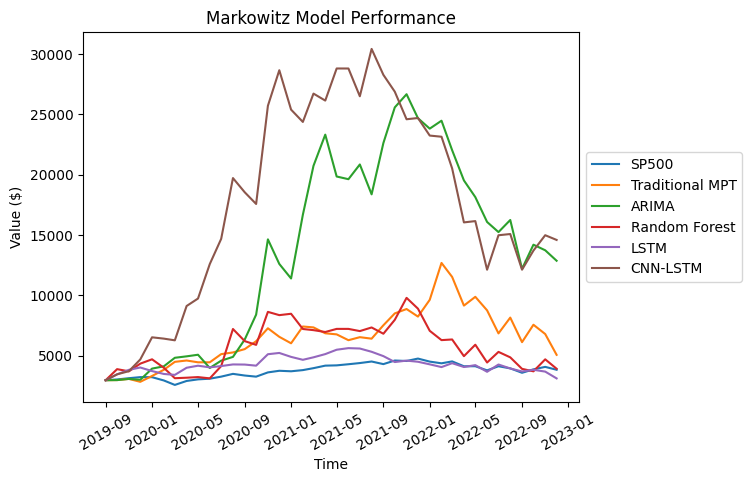

In [ ]:
markowitz_cnn = np.zeros(int(len(rf_data)/50/3+1))
sp500_comp = sp500[-len(markowitz_cnn):]
df_sim_result = pd.read_csv("/content/sim_result.csv").set_index("Unnamed: 0")

plt.plot(sp500_comp, label = "SP500")
plt.plot(sp500_comp.index,np.double(df_sim_result.iloc[0]), label = "Traditional MPT")
plt.plot(sp500_comp.index,np.double(df_sim_result.iloc[1]), label = "ARIMA")
plt.plot(sp500_comp.index,np.double(df_sim_result.iloc[2]), label = "Random Forest")
plt.plot(sp500_comp.index,np.double(df_sim_result.iloc[3]), label = "LSTM")
plt.plot(sp500_comp.index,np.double(df_sim_result.iloc[4]), label = "CNN-LSTM")

plt.title("Markowitz Model Performance")
plt.xlabel("Time")
plt.ylabel("Value ($)")
plt.xticks(rotation=30)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [ ]:
df_rmse = pd.read_csv("/content/rmse.csv").set_index("Unnamed: 0")
df_returns = pd.DataFrame({
    "Traditional" : np.double(df_sim_result.iloc[0,1:])/np.double(df_sim_result.iloc[0,:-1]) - 1,
    "ARIMA" : np.double(df_sim_result.iloc[1,1:])/np.double(df_sim_result.iloc[1,:-1]) - 1,
    "Random Forest" : np.double(df_sim_result.iloc[2,1:])/np.double(df_sim_result.iloc[2,:-1]) - 1,
    "LSTM" : np.double(df_sim_result.iloc[3,1:])/np.double(df_sim_result.iloc[3,:-1]) - 1,
    "CNN-LSTM" : np.double(df_sim_result.iloc[4,1:])/np.double(df_sim_result.iloc[4,:-1]) - 1,
})
df_returns = df_returns.T
rmse_all = np.double(np.mean(df_rmse**2, axis = 1)**0.5)
sim_mean_return = np.double(np.mean(df_returns, axis =1))
sim_var_return = np.double(np.var(df_returns,axis = 1))
sharpe_ratio = sim_mean_return/sim_var_return
sim_stats = pd.DataFrame({
    'RMSE' : rmse_all,
    'Average Returns' : sim_mean_return,
    'Variance' : sim_var_return,
    'Sharpe Ratio' : sharpe_ratio
  }, index = df_rmse.index
)
sim_stats

## MPT with Copula

In [ ]:
from copulas.multivariate import GaussianMultivariate

# Outputs the optimal weights of the portfolio given the returns matrix
# using the copula combined MVF model. (covariance matrix is replaced by
# the Gaussian copula fitted correlation matrix)

# returns should be in the form of n x m matrix:
#    n: number of stocks
#    m: number of dates
#    Each row should be a record of the returns of the stocks 
#    in a chronogical order
def optimal_portfolio_copula(returns):
    n = len(returns)
    returns = np.asmatrix(returns)

    dist = GaussianMultivariate()
    dist.fit(stocks_data_current.T)
    copula_correlation = dist.to_dict()['correlation']
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(copula_correlation)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks


In [33]:
markowitz_ef = np.zeros(int(len(rf_data)/50/3+1))
markowitz_copula = np.zeros(int(len(rf_data)/50/3+1))

sp500_comp = sp500[-len(markowitz_ef):]
markowitz_ef[0] = sp500_comp[0]
markowitz_copula[0] = sp500_comp[0]

for i in range(len(markowitz_ef)-1):
  curr_time = int(len(rf_data)/50) - int(len(rf_data)/50/3) + i
  
  stocks_data_current = stocks_data.iloc[:,i:curr_time]
  port_weight = optimal_portfolio_ef(stocks_data_current)[0]
  port_return = np.dot(port_weight.T,np.array(stocks_data.iloc[:,curr_time]))[0]
  markowitz_ef[i+1] = markowitz_ef[i]*(1+port_return)

  port_weight_copula = optimal_portfolio_copula(stocks_data_current)[0]
  port_return_copula = np.dot(port_weight_copula.T,np.array(stocks_data.iloc[:,curr_time]))[0]
  markowitz_copula[i+1] = markowitz_copula[i]*(1+port_return_copula)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  a = (self.min - loc) / scale
/usr/local/lib/python3.10/dist-packages/copulas/univariate/trunca

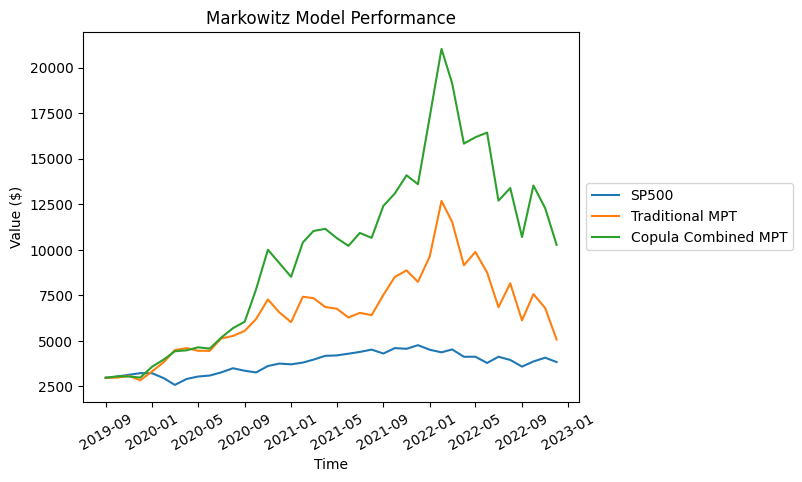

In [34]:
sp500_comp = sp500[-len(markowitz_ef):]

plt.plot(sp500_comp, label = "SP500")
plt.plot(sp500_comp.index,markowitz_ef, label = "Traditional MPT")
plt.plot(sp500_comp.index,markowitz_copula, label = "Copula Combined MPT")
plt.title("Markowitz Model Performance")
plt.xlabel("Time")
plt.ylabel("Value ($)")
plt.xticks(rotation=30)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 